In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import os
from google.colab import drive

def getAOC(data):
  AOC = []
  close = data['종가']

  # aoc = (금일 종가 - 전일 종가) / 전일 종가
  for i in range(len(close)):
    aoc_value = ((close[i] - close[i-1]) / close[i-1]) * 100
    if(i % 494 == 0):
      aoc_value = 0
    AOC.append(aoc_value)

  return AOC

drive.mount('/content/drive')

sub=pd.read_csv("./drive/MyDrive/Colab Notebooks/sample_submission.csv")
data=pd.read_csv("./drive/MyDrive/Colab Notebooks/train.csv")

#sort data by "종목명"
subject_Data=data.sort_values(by="종목명",inplace=False)
subject_Data.head()
subject_Data.columns

pv_s_data=pd.pivot_table(subject_Data,values=['거래량', '시가', '고가', '저가', '종가'],index=['종목코드','일자'])

pv_s_data["AOC"] = getAOC(pv_s_data)

divided = pv_s_data.index.get_level_values('종목코드').unique()

sliced_dataframes = []

for i in divided:
    sliced_data = pv_s_data.loc[i]
    sliced_dataframe = sliced_data.reset_index()
    sliced_dataframes.append(sliced_dataframe)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['거래량', '고가', '시가', '저가', '종가', 'AOC']
scaled = scaler.fit_transform(sliced_dataframes[3][scale_cols])

In [39]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('종가', 1), df['종가'], test_size=0.2, random_state=0, shuffle=False)

<ipython-input-26-1202195c6716>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('종가', 1), df['종가'], test_size=0.2, random_state=0, shuffle=False)


In [27]:
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [28]:
WINDOW_SIZE=20
BATCH_SIZE=32

# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [29]:
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda

model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [30]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [35]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=50)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [36]:
history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=2000,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/2000
     11/Unknown - 0s 5ms/step - loss: 0.0019 - mse: 0.0038 
Epoch 1: val_loss improved from inf to 0.00129, saving model to tmp/ckeckpointer.ckpt
12/12 [==============================] - 0s 15ms/step - loss: 0.0019 - mse: 0.0037 - val_loss: 0.0013 - val_mse: 0.0026
Epoch 2/2000
11/12 [==========================>...] - ETA: 0s - loss: 0.0018 - mse: 0.0036
Epoch 2: val_loss improved from 0.00129 to 0.00120, saving model to tmp/ckeckpointer.ckpt
12/12 [==============================] - 0s 13ms/step - loss: 0.0018 - mse: 0.0036 - val_loss: 0.0012 - val_mse: 0.0024
Epoch 3/2000
 8/12 [===================>..........] - ETA: 0s - loss: 0.0018 - mse: 0.0036
Epoch 3: val_loss improved from 0.00120 to 0.00115, saving model to tmp/ckeckpointer.ckpt
12/12 [==============================] - 0s 15ms/step - loss: 0.0018 - mse: 0.0036 - val_loss: 0.0012 - val_mse: 0.0023
Epoch 4/2000
11/12 [==========================>...] - ETA: 0s - loss: 0.0017 - mse: 0.0034
Epoch 4: val_loss did not im

3/3 [==============================] - 0s 18ms/step


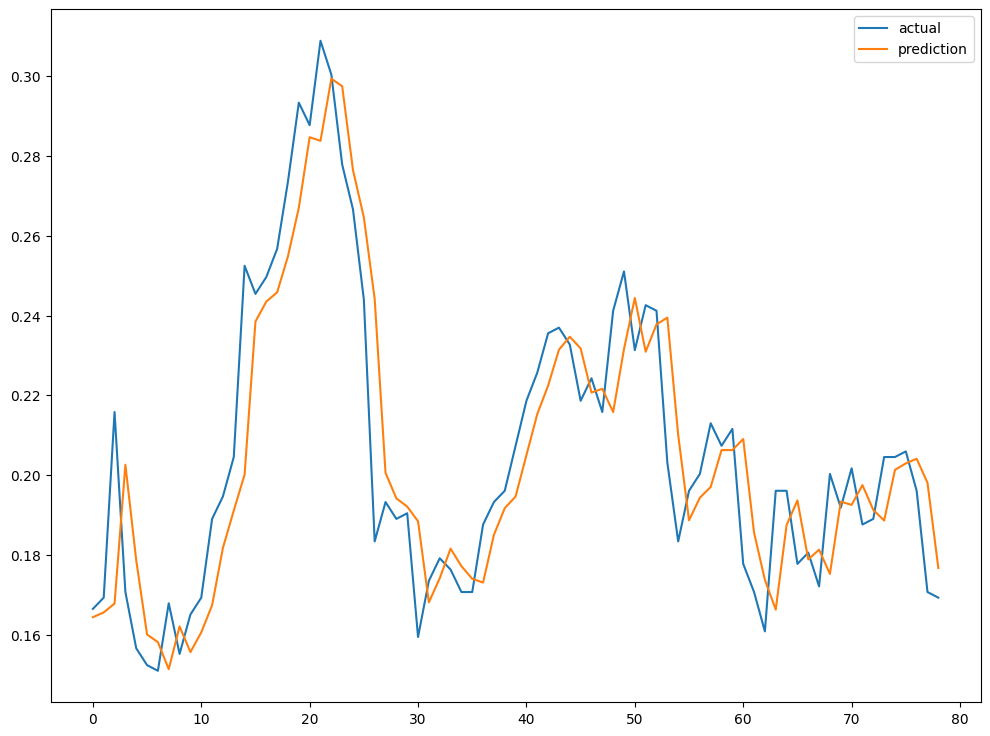

In [37]:
model.load_weights(filename)
pred = model.predict(test_data)
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()